# Baseline classification notebook

Here we provide baseline notebook for Baikal zooplankton classification with metric learning.
Notebook consists of following parts:
* Initialization - installation of packets, import
* Data fetch
* Setup Datasets
* Setup model
* Setup loss function, optimizer, etc
* Train model
* Save model
* Sample inference


## Initialization

### Installation of dependency packets

In [95]:
%pip install pytorch-metric-learning[with-hooks]
%pip install torch-lr-finder

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.
Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


## Imports section

#### Common

In [49]:
import io
import json
from pathlib import Path
import requests
import shutil

#### Computation and data representation-related imports

In [50]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

#### Here we import pytorch and pytorch-metric-learning

In [96]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms
from torchvision import models
from torchvision.datasets import ImageFolder

import pytorch_metric_learning
from pytorch_metric_learning import losses, miners, samplers, testers, trainers, distances, reducers

from pytorch_metric_learning.utils import common_functions
import pytorch_metric_learning.utils.logging_presets as logging_presets
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

from torch_lr_finder import LRFinder # for optimal learning rate

####  KNN, metrics and outlier related packets

In [52]:
from hdbscan import HDBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest

#### Logging

In [53]:
import logging
logging.getLogger().setLevel(logging.INFO)
logging.info("VERSION %s" % pytorch_metric_learning.__version__)

INFO:root:VERSION 1.6.3


#### Setup folder structure


We want to place everything under `data` directory.
* `train` is train part of dataset
* `test` is validatiion part
* `tmp` is temp directory for operations

In [54]:
root_path = Path('.')

data_path = root_path / 'data'
tmp_path = data_path/ 'tmp'
train_path = data_path / 'train'
test_path = data_path / 'test'

if not train_path.exists():
    data_path.mkdir(parents=True, exist_ok=True)
    tmp_path.mkdir(parents=True,exist_ok=True)
    train_path.mkdir(parents=True,exist_ok=True)
    test_path.mkdir(parents=True,exist_ok=True)

## Fetch data

From repository obtain file `data.json` and load it

In [55]:
with open('data.json') as f:
    data = json.load(f)

Remove `other` directory for now.

We will train network on known-samples, `other` is a tag for dirt, fito-plankton and other objects not intended for recognition.

But we can use `other` as test for outliers.

In [56]:
objects = [item for item in data if item['category']!= 'other']

In [57]:
objects_train, objects_test = train_test_split(objects, test_size=0.1)

In [58]:
print(f'Amount of objects in train pool: {len(objects_train)}')

Amount of objects in train pool: 27364


In [59]:
print(f'Amount of objects in test pool: {len(objects_test)}')

Amount of objects in test pool: 3041


Helper to download files from public-available links:

In [60]:

def download_file(url, local_path):
    if Path(local_path).exists():
        return 
    with requests.get(url, stream=True) as r:
        with open(local_path, 'wb') as f:
            shutil.copyfileobj(r.raw, f)

Helper, that downloads big files with sample shots and cuts rectangles with objects inside. Then stores these objects in destination folder.

In [61]:
def get_dataset_from_objects(source_objects_list, dst_dir):
    cat_counts = {}
    for obj in source_objects_list:
        image_path = str(tmp_path/ 'img.jpg')
        download_file(obj['image'], image_path)
        big_img = Image.open(image_path)
        left = 1
        top=1
        bottom=0
        right=0
        for pt in obj['points']:
            left = min(pt['x'],left)
            right = max(pt['x'], right)
            top = min(pt['y'], top)
            bottom = max(pt['y'], bottom)
        left = int(left*big_img.width)
        right = int(right*big_img.width)
        top = int(top* big_img.height)
        bottom = int(bottom* big_img.height)
        (dst_dir / obj['category']).mkdir(parents=True, exist_ok=True)
        if obj['category'] not in cat_counts:
            cat_counts[obj['category']] = 1
        else:
            cat_counts[obj['category']] += 1

        big_img.crop((left, top, right, bottom)).save(dst_dir /obj['category']/ f"{cat_counts[obj['category']]}.jpg")

#### Download dataset
Both train and test

In [62]:
#get_dataset_from_objects(objects_train,train_path)

In [63]:
#get_dataset_from_objects(objects_test,test_path)

Set number of classes

In [64]:
num_classes = len(set([item['category'] for item in data]))-1

#### Define input image size

In [65]:
input_img_size = (224,224)

Define transforms for images

In [93]:
train_transform = transforms.Compose(
    [
        transforms.Resize(input_img_size),
        transforms.RandomHorizontalFlip(0.5),
        transforms.RandomVerticalFlip(0.5),
     #   transforms.RandomAutocontrast(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

test_transform = transforms.Compose(
    [
        transforms.Resize(input_img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [94]:
train_set = ImageFolder(str(train_path), transform=train_transform)

In [68]:
test_set = ImageFolder(str(test_path), transform=test_transform)

Here we declare torch device. We are using Yandex.Cloud environment with 1xV100 Tesla GPU.

In [70]:
#!g1.1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Build model

#### Define embedding size

In [71]:
#!g1.1
embedding_size = 128

Define model.
Model structure is following:
1. Resnet18 feature extractor
2. Layer for embeddings

In [72]:
#!g1.1
model = models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /tmp/xdg_cache/torch/hub/checkpoints/resnet18-f37072fd.pth


In [73]:
#!g1.1
embedding_layer_in_size = model.fc.in_features
embedder = nn.Linear(embedding_layer_in_size, embedding_size)
model.fc=embedder

#### Define optimizer.  

In [102]:
#!g1.1
learning_rate = 1e-7
weight_decay=0.0001

In [103]:
#!g1.1

embedder_optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

#### Define loss

Here we use CircleLoss from https://arxiv.org/pdf/2002.10857.pdf

In [77]:
#!g1.1
loss = losses.CircleLoss()

#### Define train and test procedures.

In [78]:
#!g1.1
def train(model, loss_func, mining_func, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, labels) in enumerate(train_loader):
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        embeddings = model(data)
        indices_tuple = mining_func(embeddings, labels)
        loss = loss_func(embeddings, labels, indices_tuple)
        loss.backward()
        optimizer.step()
        if batch_idx % 20 == 0:
            print(
                "Epoch {} Iteration {}: Loss = {}".format(
                    epoch, batch_idx, loss#, mining_func.num_triplets
                )
            )



In [118]:
#!g1.1

### convenient function from pytorch-metric-learning ###
def get_all_embeddings(dataset, model):
    tester = testers.BaseTester()
    return tester.get_all_embeddings(dataset, model)


### compute accuracy using AccuracyCalculator from pytorch-metric-learning ###
def test(train_set, test_set,  model, accuracy_calculator):
    train_embeddings, train_labels = get_all_embeddings(train_set, model)
    test_embeddings, test_labels = get_all_embeddings(test_set, model)
    train_labels = train_labels.squeeze(1)
    test_labels = test_labels.squeeze(1)
    print("Computing accuracy")
    accuracies = accuracy_calculator.get_accuracy(
        test_embeddings, train_embeddings, test_labels, train_labels, False
    )
    print("Test set accuracy (Precision@1) = {}".format(accuracies["precision_at_1"]))
    

#### Define batch size

In [80]:
#!g1.1
batch_size=64

#### Define data loaders

In [81]:
#!g1.1
train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)

#### Define number of epochs 

In [82]:
#!g1.1
num_epochs = 5

##### Define helpers from Pytorch metric learning packet.

Here we use several helpers:
* Cosine distance - to impicitly enforce cosine distance in embeddings by mining pairs for loss computation.
* TripletMarginMiner - selects only triplets, which have some distance between positive-anchor and negative-anchor using cosine distance concordant with loss function. 
* MeanReducer - averages loss from each pair to provide global loss.

In [83]:
#!g1.1
distance = distances.CosineSimilarity()
reducer = reducers.AvgNonZeroReducer()
mining_func = miners.TripletMarginMiner( distance =distance, type_of_triplets='hard')

#### Declare accuracy calculator.

In [84]:
#!g1.1
accuracy_calculator = AccuracyCalculator(include=("precision_at_1", "AMI"), k=1)

#### Push model to GPU.

In [85]:
#!g1.1
model = model.to(device)


Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.71E-03


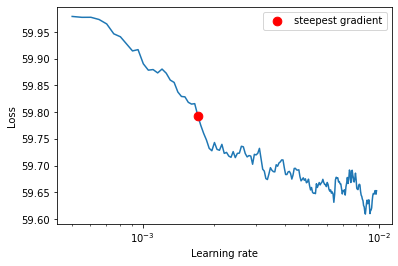

In [125]:
#!g1.1
lr_finder = LRFinder(model, embedder_optimizer, loss, device=device)
range_test_result = lr_finder.range_test(train_loader, start_lr=1e-10, end_lr=1e-2, num_iter=500, step_mode='linear')
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [126]:
#!g1.1
lrs = lr_finder.history['lr']
losses = lr_finder.history['loss']
learning_rate =lrs[np.argmin(losses)]

In [133]:
#!g1.1
learning_rate = 1e-4

New learning rate based on LRFinder and reinit optimizer.

In [134]:
#!g1.1
embedder_optimizer  = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=weight_decay
)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer=embedder_optimizer,
                                            step_size=10, gamma=0.1)

#### Train model

In [135]:
#!g1.1
for epoch in range(1, num_epochs + 1):
    train(model, loss, mining_func, device, train_loader, embedder_optimizer, epoch)
    test(train_set, test_set, model, accuracy_calculator)
    scheduler.step()
    

100%|██████████| 49/49 [00:12<00:00,  3.96it/s]
WARNING clustering 1546 points to 60 centroids: please provide at least 2340 training points
100%|██████████| 49/49 [00:12<00:00,  4.08it/s]
WARNING clustering 1546 points to 60 centroids: please provide at least 2340 training points
100%|██████████| 49/49 [00:11<00:00,  4.23it/s]
WARNING clustering 1546 points to 60 centroids: please provide at least 2340 training points
100%|██████████| 49/49 [00:11<00:00,  4.15it/s]
WARNING clustering 1546 points to 60 centroids: please provide at least 2340 training points
100%|██████████| 49/49 [00:12<00:00,  3.91it/s]
WARNING clustering 1546 points to 60 centroids: please provide at least 2340 training points


Epoch 1 Iteration 0: Loss = 58.478302001953125
Epoch 1 Iteration 20: Loss = 58.05998992919922
Epoch 1 Iteration 40: Loss = 58.303245544433594
Epoch 1 Iteration 60: Loss = 57.9961051940918
Epoch 1 Iteration 80: Loss = 58.47608184814453
Epoch 1 Iteration 100: Loss = 58.2823600769043
Epoch 1 Iteration 120: Loss = 58.17644119262695
Epoch 1 Iteration 140: Loss = 58.41024398803711
Epoch 1 Iteration 160: Loss = 58.20237350463867
Epoch 1 Iteration 180: Loss = 58.05975341796875
Epoch 1 Iteration 200: Loss = 58.419185638427734
Epoch 1 Iteration 220: Loss = 58.19075393676758
Epoch 1 Iteration 240: Loss = 57.9739875793457
Epoch 1 Iteration 260: Loss = 58.466705322265625
Epoch 1 Iteration 280: Loss = 58.43385314941406
Epoch 1 Iteration 300: Loss = 58.161468505859375
Epoch 1 Iteration 320: Loss = 58.52412796020508
Epoch 1 Iteration 340: Loss = 58.25364303588867
Epoch 1 Iteration 360: Loss = 58.340293884277344
Epoch 1 Iteration 380: Loss = 58.45124053955078
Epoch 1 Iteration 400: Loss = 58.5080871582

Precision@1(how many closest points are correct) is not impressive! But dont be desperate. It is slowly learning and dataset is full of quirks.

Precision@1 is not very informative metric in terms of end 


## Time to save model to onnx runtime 

Model will appear under name `embedder.onnx`. 

In [142]:
x = torch.randn(1, 3, input_img_size[0], input_img_size[1], requires_grad=True) #sample input
torch.onnx.export(
    model.to('cpu'), 
    x,
    'embedder.onnx',
    export_params=True,
    do_constant_folding=True,
input_names = ['input'],   # the model's input names
                  output_names = ['output'], # the model's output names
                  dynamic_axes={'input' : {0 : 'batch_size'},    # variable length axes
                                'output' : {0 : 'batch_size'}})